<a href="https://colab.research.google.com/github/leesanghoit/KNUT-LIKELION-12th/blob/main/11_training_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**11장 – 심층 신경망 훈련하기**

_이 노트북에는 11장의 모든 샘플 코드와 연습 문제에 대한 솔루션이 포함되어 있습니다._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 11.0 설정

이 프로젝트에는 파이썬 3.7 이상이 필요합니다:

In [30]:
import sys

assert sys.version_info >= (3, 7)

그리고 텐서플로 ≥ 2.8:

In [31]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

이전 장에서와 마찬가지로 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [32]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

그리고 `images/deep` 폴더를 만들고(아직 존재하지 않는 경우), 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의하겠습니다:

In [33]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 11.1 그레이디언트 소실과 폭주 문제

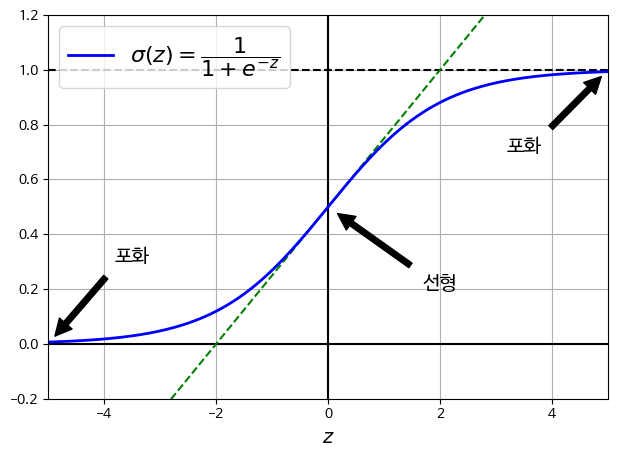

In [34]:
# 추가 코드 - 이 셀은 그림 11-1을 생성하고 저장합니다.

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('포화', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('포화', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('선형', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

## 11.1.1 Xavier 초기화와 He 초기화

In [35]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [36]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

## 11.1.2 수렴하지 않는 활성화 함수

### LeakyReLU

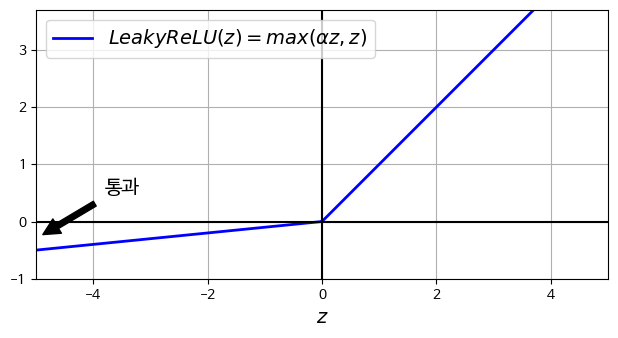

In [37]:
# 추가 코드 - 이 셀은 그림 11-2를 생성하고 저장합니다.

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('통과', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

In [38]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # 기본값 alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [39]:
model = tf.keras.models.Sequential([
    # [...]  # 다른 층
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # 활성화 함수 없음
    tf.keras.layers.LeakyReLU(alpha=0.2),  # 별도의 층으로 활성화 함수 추가
    # [...]  # 다른 층
])

### ELU

텐서플로에서 ELU를 구현하는 것은 간단합니다. 층을 만들 때 활성화 함수를 지정하고 He 초기화를 사용하기만 하면 됩니다:

In [40]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

### SELU

기본적으로 SELU 하이퍼파라미터(`scale` 및 `alpha`)는 각 뉴런의 평균 출력이 0, 표준편차가 1에 가깝게 유지되도록 튜닝됩니다(책에서 설명한 대로 입력도 평균 0과 표준편차 1로 표준화되고 다른 제약 조건이 준수된다고 가정합니다). 이 활성화 함수를 사용하면 1,000개 층을 가진 심층 신경망에서도 모든 층에서 대략 평균 0과 표준편차 1을 유지하여 기울기가 폭주/소멸하는 문제를 피할 수 있습니다:

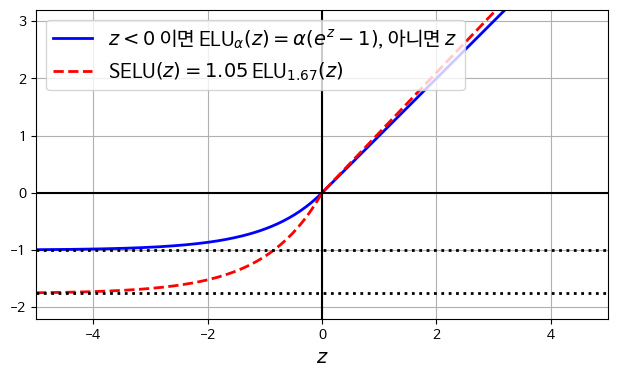

In [41]:
# 추가 코드 - 이 셀은 그림 11-3을 생성하고 저장합니다.

from scipy.special import erfc

# 평균 0, 표준 편차 1로 자체 정규화하기 위한 alpha 및 sacle
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"$z < 0$ 이면 ELU$_\alpha(z) = \alpha (e^z - 1)$, 아니면 $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

SELU 사용법은 간단합니다:

In [42]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

**추가 자료 - SELU를 사용한 자기 정규화된 네트워크의 예시**

SELU 활성화 함수를 사용하여 100개의 은닉층이 있는 패션 MNIST용 신경망을 만들어 보겠습니다:

In [43]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [44]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

이제 훈련해 봅시다. 입력값을 평균 0, 표준편차 1로 스케일링하는 것을 잊지 마세요:

In [45]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [46]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [47]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [48]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.5182 - loss: 1.2949 - val_accuracy: 0.7500 - val_loss: 0.7279
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7525 - loss: 0.6839 - val_accuracy: 0.7550 - val_loss: 0.6678
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.7890 - loss: 0.5793 - val_accuracy: 0.8064 - val_loss: 0.5389
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8177 - loss: 0.5205 - val_accuracy: 0.8146 - val_loss: 0.5168
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8353 - loss: 0.4727 - val_accuracy: 0.7844 - val_loss: 0.5739


신경망이 매우 깊은데도 학습에 성공했습니다. 이제 ReLU 활성화 함수를 대신 사용하면 어떤 일이 발생하는지 살펴보겠습니다:

In [49]:
tf.random.set_seed(42)

In [50]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [51]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [52]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.1836 - loss: 2.0984 - val_accuracy: 0.3686 - val_loss: 1.4935
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.4433 - loss: 1.3105 - val_accuracy: 0.5512 - val_loss: 1.0449
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.5730 - loss: 1.0256 - val_accuracy: 0.6382 - val_loss: 0.9772
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.6179 - loss: 0.9408 - val_accuracy: 0.6946 - val_loss: 0.8247
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.6835 - loss: 0.8252 - val_accuracy: 0.6054 - val_loss: 0.9911


좋지 않네요. 그레이디언트 소멸/폭주 문제로 인해 어려움을 겪습니다.

### GELU, Swish, Mish

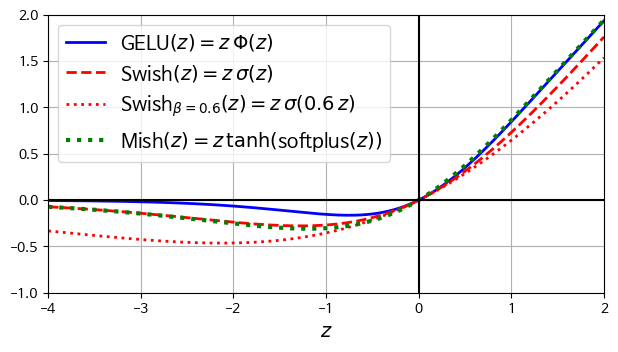

In [53]:
# 추가 코드 - 이 셀은 그림 11-4를 생성하고 저장합니다.

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

## 11.1.3 배치 정규화

In [54]:
# 추가 코드 - 이름 카운터를 지우고 랜덤 시드를 설정합니다.
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [55]:
# slide 19...
# model = ...

In [56]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_110 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_111 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_112 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_120 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_121 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_122 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_123 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_124 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_125 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_126 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,079,412 (4.12 MB)

 Trainable params: 1,079,410 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [57]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('kernel', True), ('bias', True)]

In [58]:
# 추가 코드 - 모델이 작동한다는 것을 보여주기만 하면 됩니다! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

ValueError: Expected `metrics` argument to be a list, tuple, or dict. Received instead: metrics=accuracy of type <class 'str'>

때때로 활성화 함수 전에 BN을 적용하는 것이 더 효과적일 수 있습니다(이 주제에 대한 논쟁이 있습니다). 또한, `BatchNormalization` 앞의 층에는 편향 항이 필요하지 않습니다. 따라서 편향이 있으면 파라미터가 낭비될 수 있으므로 층을 생성할 때 `use_bias=False`로 지정할 수 있습니다:

In [ ]:
# 추가 코드 - 이름 카운터를 지우고 무작위 시드를 설정합니다.
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
# slide 22...
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
# 추가 코드 - 모델이 작동한다는 것을 보여주기만 하면 됩니다! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

## 11.1.4 그레이디언트 클리핑

모든 `tf.keras.optimizers`는 `clipnorm` 또는 `clipvalue` 매개변수를 받습니다:

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

# 11.2 사전 훈련된 층 재사용

### 케라스 모델 재사용

패션 MNIST 훈련 집합을 두 개로 나눠 보겠습니다:
* `X_train_A`: T-shirts/tops와 pullovers를 제외한 모든 항목의 모든 이미지 (클래스 0과 2).
* `X_train_B`: T-shirts/tops와 pullovers 중에서 처음 200개의 이미지로만 구성된 훨씬 작은 훈련 세트.

검증 세트와 테스트 세트도 이러한 방식으로 분할되지만 이미지 수에는 제한이 없습니다.

집합 A(8개의 클래스가 있는 분류 작업)에 대해 모델을 훈련하고, 이를 다시 집합 B(이진 분류)를 처리하는 데 사용하려고 합니다. 집합 A의 클래스(trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots)는 집합 B의 클래스(T-shirts/tops, pullovers)과 다소 유사하므로, 작업 A에서 작업 B로 약간의 지식이 전이되기를 희망합니다.

그러나 `Dense` 층을 사용하기 때문에 같은 위치에서 발생하는 패턴만 재사용할 수 있습니다(하지만 14장에서 살펴볼 합성곱 층은 학습된 패턴을 이미지의 어느 위치에서나 감지할 수 있습니다).

In [ ]:
# 추가 코드 - 패션 MNIST를 작업 A와 B로 분할한 다음 모델 A를 학습하고 "my_model_A"에 저장합니다.

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # A에 대한 클래스 ID 재정의
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

In [ ]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

모델 B는 테스트 세트에서 91.85%의 정확도에 도달했습니다. 이제 사전 학습된 모델 A를 재사용해 보겠습니다.

In [ ]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

`model_B_on_A`와 `model_A`는 층을 실제 공유하므로 하나를 훈련하면 두 모델이 모두 업데이트됩니다. 이를 방지하려면 `model_A`의 *복제하여* `model_B_on_A`를 만들어야 합니다:

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장

In [ ]:
# slide 29...
# model_A_clone = ...

In [ ]:
# 추가 코드 - 이전 셀에서와 마찬가지로 model_B_on_A를 생성합니다.
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [ ]:
# slide 30...
# history = ...

그렇다면 최종 판결은 어떻게 되나요?

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

훌륭합니다! 모델의 정확도가 91.85%에서 93.85%로 2% 포인트 상승했습니다. 이는 오류율이 거의 25% 감소했음을 의미합니다:

In [ ]:
1 - (100 - 93.85) / (100 - 91.85)

# 11.3 고급 옵티마이저

In [ ]:
# 추가 코드 - 패션 MNIST에서 옵티마이저를 테스트하는 간단한 함수

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [ ]:
history_sgd = build_and_train_model(optimizer)  # 추가 코드

## 11.3.1 모멘텀 최적화

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [ ]:
history_momentum = build_and_train_model(optimizer)  # 추가 코드

## 11.3.2 네스테로프 가속 경사

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [ ]:
history_nesterov = build_and_train_model(optimizer)  # 추가 코드

## 11.3.3 AdaGrad

In [ ]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [ ]:
history_adagrad = build_and_train_model(optimizer)  # 추가 코드

## 11.3.4 RMSProp

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [ ]:
history_rmsprop = build_and_train_model(optimizer)  # 추가 코드

## 11.3.5 Adam

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [ ]:
history_adam = build_and_train_model(optimizer)  # 추가 코드

## 11.3.6 Adamax

In [ ]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [ ]:
history_adamax = build_and_train_model(optimizer)  # 추가 코드

## 11.3.7 Nadam

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [ ]:
history_nadam = build_and_train_model(optimizer)  # 추가 코드

## 11.3.8 AdamW

TF 1.12부터 `AdamW`가 experimental에서 벗어났습니다.

In [ ]:
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                      beta_1=0.9, beta_2=0.999)

In [ ]:
history_adamw = build_and_train_model(optimizer)  # 추가 코드

In [ ]:
# 추가 코드 - 모든 옵티마이저의 학습 곡선 시각화

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("에포크")
    plt.ylabel({"loss": "훈련 손실", "val_loss": "검증 손실"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## 11.3.9 학습률 스케줄링

### 거듭제곱 기반 스케줄링

learning_rate = initial_learning_rate / (1 + step / decay_steps)**power

케라스는 `power = 1`을 사용합니다.

**노트**: 옵티마이저의 `decay` 매개변수는 deprecated 되었습니다. `decay` 매개변수를 가진 구형 옵티마이저는 `tf.keras.optimizers.legacy`에 아직 있습니다. 하지만 그대신 `tf.keras.optimizers.schedules`를 사용해야 합니다.

In [ ]:
# DEPRECATED:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

In [ ]:
# RECOMMENDED:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

`InverseTimeDecay` 스케줄러는 `learning_rate = initial_learning_rate / (1 + decay_rate * step / decay_step)`를 사용합니다. `staircase = True`로 지정하면 `step / decay_steps`를 `floor(step / decay_step)`으로 바꿉니다.

In [ ]:
history_power_scheduling = build_and_train_model(optimizer)  # 추가 코드

In [ ]:
# 추가 코드 - 이 셀은 거듭제곱 기반 스케줄링을 표시합니다.

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("스텝")
plt.ylabel("학습률")
plt.title("거듭제곱 기반 스케줄링", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### 지수 기반 스케줄링

```python
learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)
```

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
history_exponential_scheduling = build_and_train_model(optimizer)  # 추가 코드

In [ ]:
# 추가 코드 - 이 셀은 지수 기반 스케줄링을 표시합니다.

initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("스텝")
plt.ylabel("학습률")
plt.title("지수 기반 스케줄링", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

케라스는 사용자 정의 스케줄링 함수를 위해 `LearningRateScheduler` 콜백 클래스를 제공합니다. 이를 사용해 지수 기반 감쇠를 구현하는 방법을 살펴 보겟습니다. 여기에서는 스텝이 아니라 에포크마다 학습률이 바뀝니다.

In [ ]:
# slide 50...
def exponential_decay_fn(epoch):
    # return ...

In [ ]:
# slide 50...
def exponential_decay(lr0, s):
    # ...

In [ ]:
# 추가 코드 - 패션 MNIST용 모델 빌드 및 컴파일

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epochs = 20

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

또는 스케줄 함수가 현재 학습률을 두 번째 인수로 받을 수 있습니다:

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

**추가 자료**: 각 에포크가 아닌 각 반복마다 학습률을 업데이트하는 사용자 정의 스케줄링 함수를 사용하려면 자체 콜백 클래스를 작성할 수 있습니다:

In [ ]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # 참고: `batch` 인수는 각 에포크마다 재설정됩니다.
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [ ]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
import math

batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

### 구간별 고정 스케줄링

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
history_piecewise_scheduling = build_and_train_model(optimizer)  # 추가 코드

In [ ]:
# 추가 코드 - 이 셀은 구간별 고정 스케줄링을 표시합니다.

boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("스텝")
plt.ylabel("학습률")
plt.title("구간별 고정 스케줄링", fontsize=14)
plt.grid(True)
plt.show()

지수 기반 스케줄링에서 했던 것처럼 구간별 고정 스케줄링을 수동으로 구현할 수도 있습니다:

In [ ]:
# slide 51...
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [ ]:
# 추가 코드 - 이 셀은 구간별 고정 스케줄링을 정의하는 일반적인 방법을 보여줍니다.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
# 추가 코드 - 이전과 같이 tf.keras.callbacks.LearningRateScheduler를 사용합니다.

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

지금까지 `InverseTimeDecay`, `ExponentialDecay`, `PiecewiseConstantDecay`를 살펴 보았습니다. `tf.keras.optimizers.schedules`에는 이외에 몇 개의 스케줄러가 더 있습니다. 전체 리스트는 다음과 같습니다.

In [ ]:
for name in sorted(dir(tf.keras.optimizers.schedules)):
    if name[0] == name[0].lower():  # must start with capital letter
        continue
    scheduler_class = getattr(tf.keras.optimizers.schedules, name)
    print(f"• {name} – {scheduler_class.__doc__.splitlines()[0]}")

### 성능 기반 스케줄링

In [ ]:
# 추가 코드 - 모델 빌드 및 컴파일

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

In [ ]:
# 추가 코드 - 이 셀은 성능 기반 스케줄링을 표시합니다.

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("에포크")
plt.ylabel("학습률", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('검증 손실', color='r')
ax2.tick_params('y', colors='r')

plt.title("평탄 지역에서 LR 감소하기", fontsize=14)
plt.show()

### 1사이클 스케줄링

`ExponentialLearningRate` 사용자 지정 콜백은 훈련의 각 배치가 끝날 때마다 학습률을 업데이트합니다. 학습률에 상수 `factor`를 곱합니다. 또한 각 배치에서 학습률과 손실을 저장할 수 있습니다. `logs["loss"]`는 실제로 에포크 시작 이후의 평균 손실인데 우리는 대신 배치 손실을 저장하고 싶습니다. 따라서 에포크 시작 이후 배치 횟수의 평균을 계산하여 지금까지의 총 손실을 구한 다음 이전 배치의 총 손실을 빼서 현재 배치의 손실을 구해야 합니다.

In [ ]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # 지금까지의 평균 손실
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

`find_learning_rate()` 함수는 `ExponentialLearningRate` 콜백을 사용하여 모델을 훈련하고 학습률과 해당 배치 손실을 반환합니다. 마지막에는 모델과 해당 옵티마이저를 초기 상태로 복원합니다.

In [ ]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

`plot_lr_vs_loss()` 함수는 학습률과 손실을 플롯합니다. 1사이클의 최대 학습률로 사용할 최적의 학습률은 곡선의 맨 아래에 있습니다.

In [ ]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("학습률")
    plt.ylabel("손실")
    plt.grid()

간단한 패션 MNIST 모델을 빌드하고 컴파일해 보겠습니다:

In [ ]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

이제 1사이클에 대한 최적의 최대 학습률을 찾아보겠습니다:

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

1사이클에 사용할 수 있는 최대 학습률은 10<sup>-1</sup> 정도인 것 같습니다.

`OneCycleScheduler` 사용자 지정 콜백은 각 배치가 시작될 때 학습률을 업데이트합니다. 이 책에 설명된 논리를 적용합니다. 훈련의 약 절반 동안 학습 속도를 선형적으로 증가시킨 다음, 다시 초기 학습 속도로 선형적으로 감소시키고, 마지막으로 훈련의 마지막 부분에서는 학습 속도를 선형적으로 0에 가깝게 감소시킵니다.

In [ ]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

간단한 패션 MNIST 모델을 빌드하고 컴파일한 다음 `OneCycleScheduler` 콜백을 사용하여 훈련해 보겠습니다:

In [ ]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

# 11.4 규제를 통한 과적합 방지

## 11.4.1 $\ell_1$과 $\ell_2$ 규제

In [ ]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

또는 계수가 0.1인 ℓ<sub>1</sub> 정규화의 경우 `l1(0.1)`을 사용하거나, 계수가 각각 0.1과 0.01인 ℓ<sub>1</sub> 및 ℓ<sub>2</sub> 정규화의 경우 `l1_l2(0.1, 0.01)`을 사용합니다.

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성을 위한

In [ ]:
# slide 54...
from functools import partial

# RegularizedDense = ...

In [ ]:
# 추가 코드 - 모델 컴파일 및 훈련
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

## 11.4.2 드롭아웃

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성을 위한

In [ ]:
# slide 56...
model = tf.keras.Sequential([
    # layers...
])

In [ ]:
# 추가 코드 - 모델 컴파일 및 훈련
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

훈련 정확도가 검증 정확도보다 낮은 것처럼 보이지만 이는 드롭아웃이 훈련 중에만 활성화되기 때문입니다. 훈련 후(즉, 드롭아웃을 끈 상태에서) 훈련 세트에서 모델을 평가하면 검증 정확도 및 테스트 정확도보다 약간 높은 "실제" 훈련 정확도를 얻을 수 있습니다:

In [ ]:
model.evaluate(X_train, y_train)

In [ ]:
model.evaluate(X_test, y_test)

**참고**: SELU를 사용하여 자가 정규화 신경망을 구축하려면 `Dropout` 대신 `AlphaDropout`을 사용해야 합니다.

## 11.4.3 MC 드롭아웃

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성을 위한

In [ ]:
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [ ]:
model.predict(X_test[:1]).round(3)

In [ ]:
y_proba[0].round(3)

In [ ]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

In [ ]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

In [ ]:
# slide 58...
class MCDropout(tf.keras.layers.Dropout):
    # ...

In [ ]:
# 추가 코드 - 시퀀셜 모델에서 Dropout을 MCDropout으로 변환하는 방법을 보여줍니다.
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [ ]:
mc_model.summary()

이제 MC 드롭아웃과 함께 모델을 사용할 수 있습니다:

In [ ]:
# 추가 코드 - 모델을 재훈련하지 않고 사용하는 방법을 보여줍니다.
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

## 11.4.4 맥스-노름

In [ ]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [ ]:
# 추가 코드 - 모델의 모든 은닉층에 맥스-노름을 적용하는 방법을 보여줍니다.
MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

---
# 연습문제 해답

## 1. to 7.

부록 A 참조

## 8. CIFAR10에 딥러닝 적용하기

### a.
*문제: 100개의 뉴런을 가진 은닉층 20개로 심층 신경망을 만들어보세요(너무 많은 것 같지만 이 연습문제의 핵심입니다). He 초기화와 Swish 활성화 함수를 사용하세요.*

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    activation="swish",
                                    kernel_initializer="he_normal"))

### b.
*문제: Nadam 옵티마이저와 조기 종료를 사용하여 CIFAR10 데이터셋에 이 네트워크를 훈련하세요. ㅅ`tf.keras.datasets.cifar10.load_ data()`를 사용하여 데이터를 적재할 수 있습니다. 이 데이터셋은 10개의 클래스와 32×32 크기의 컬러 이미지 60,000개로 구성됩니다(50,000개는 훈련, 10,000개는 테스트). 따라서 10개의 뉴런과 소프트맥스 활성화 함수를 사용하는 출력층이 필요합니다. 모델 구조와 하이퍼파라미터를 바꿀 때마다 적절한 학습률을 찾아야 한다는 것을 기억하세요.*

모델에 출력층을 추가합니다:

In [ ]:
model.add(tf.keras.layers.Dense(10, activation="softmax"))

학습률이 5e-5인 Nadam 옵티마이저를 사용해 보겠습니다. 학습률 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 및 1e-2를 시도하고 각각 10개의 에포크에 대한 학습 곡선을 비교했습니다(아래 TensorBoard 콜백을 사용). 3e-5와 1e-4의 학습률이 꽤 좋았기 때문에 5e-5를 사용해 보았는데, 이 학습률이 약간 더 나은 것으로 나타났습니다.

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

CIFAR10 데이터 세트를 로드해 보겠습니다. 또한 조기 종료를 사용하려고 하므로 검증 세트가 필요합니다. 원본 훈련 세트의 처음 5,000개의 이미지를 검증 세트로 사용하겠습니다:

In [ ]:
cifar10 = tf.keras.datasets.cifar10.load_data()
(X_train_full, y_train_full), (X_test, y_test) = cifar10

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

이제 필요한 콜백을 생성하고 모델을 학습시킬 수 있습니다:

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_model",
                                                         save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가합니다.
run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_cifar10_logs

In [ ]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

In [ ]:
model.evaluate(X_valid, y_valid)

검증 손실이 가장 낮은 모델은 검증 세트에서 약 46.8%의 정확도를 얻었습니다. 가장 낮은 검증 손실에 도달하는 데 29개의 에포크가 걸렸으며, 제 노트북(GPU 없음)에서는 에포크당 약 10초가 걸렸습니다. 배치 정규화를 사용하여 모델을 개선할 수 있는지 살펴봅시다.

### c.
*문제: 배치 정규화를 추가하고 학습 곡선을 비교해보세요. 이전보다 빠르게 수렴하나요? 더 좋은 모델이 만들어지나요? 훈련 속도에는 어떤 영향을 미치나요?*

아래 코드는 위의 코드와 매우 유사하지만 몇 가지 다른 점이 있습니다:

* 출력층을 제외한 모든 `Dense` 레이어(활성화 함수 전) 다음에 BN 레이어를 추가했습니다.
* 학습률을 5e-4로 변경했습니다. 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3으로 실험한 결과 20회 에포크 후 가장 좋은 검증 성능을 보인 것을 선택했습니다.
* 실행 디렉터리의 이름을 run_bn_*로, 모델 파일 이름을 `my_cifar10_bn_model`로 변경했습니다.

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("swish"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_bn_model",
                                                         save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가합니다.
run_logdir = Path() / "my_cifar10_logs" / f"run_bn_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid, y_valid)

* *모델이 이전보다 더 빠르게 수렴하고 있나요?* 훨씬 빨라졌습니다! 이전 모델은 최저 검증 손실에 도달하는 데 29개의 에포크가 걸렸지만, 새로운 모델은 단 12개의 에포크에서 동일한 손실을 달성하고 17번째 에포크까지 계속 발전했습니다. BN 레이어를 통해 학습이 안정화되고 훨씬 더 큰 학습 속도를 사용할 수 있었기 때문에 수렴도 더 빨라졌습니다.
* *BN이 더 나은 모델을 생성하나요?* 네! 최종 모델의 검증 정확도도 46.7%가 아닌 50.7%로 훨씬 더 좋아졌습니다. 여전히 아주 좋은 모델은 아니지만 적어도 이전보다는 훨씬 나아졌습니다(합성곱 신경망이라면 훨씬 더 잘할 수 있지만 이는 다른 주제입니다. 14장 참조).
* *BN이 훈련 속도에 어떤 영향을 미쳤나요?* 모델이 훨씬 빠르게 수렴했지만, BN 층에 필요한 추가 계산으로 인해 각 에포크마다 10초가 아닌 약 15초가 걸렸습니다. 하지만 전체적으로 최적의 모델에 도달하는 데 걸리는 훈련 시간(실제 시간)은 약 10% 정도 단축되었습니다.

### d.
*문제: 배치 정규화를 SELU로 바꾸어보세요. 네트워크가 자기 정규화하기 위해 필요한 변경 사항을 적용해보세요(즉, 입력 특성 표준화, 르쿤 정규분포 초기화, 완전 연결 층만 순차적으로 쌓은 심층 신경망 등).*

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_selu_model", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가합니다.
run_logdir = Path() / "my_cifar10_logs" / f"run_selu_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

이 모델은 단 8개의 에포크 만에 첫 번째 모델의 검증 손실에 도달했습니다. 14개의 에포크 후에 약 50.3%의 정확도로 가장 낮은 검증 손실에 도달했는데, 이는 원래 모델(46.7%)보다는 좋지만 배치 정규화를 사용한 모델(50.7%)에는 미치지 못하는 수치입니다. 각 에포크는 9초밖에 걸리지 않았습니다. 따라서 지금까지 학습하는 데 가장 빠른 모델입니다.

### e.
*문제: 알파 드롭아웃으로 모델에 규제를 적용해보세요. 그다음 모델을 다시 훈련하지 않고 MC 드롭아웃으로 더 높은 정확도를 얻을 수 있는지 확인해보세요.*

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_alpha_dropout_model", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가합니다.
run_logdir = Path() / "my_cifar10_logs" / f"run_alpha_dropout_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

이 모델은 검증 세트에서 48.1%의 정확도를 달성했습니다. 이는 드롭아웃이 없는 경우(50.3%)보다 나쁩니다. 광범위한 하이퍼파라미터 탐색을 사용하면 더 나은 결과를 얻을 수 있지만(드롭아웃 비율 5%, 10%, 20%, 40%, 학습률 1e-4, 3e-4, 5e-4, 1e-3으로 시도해 보았습니다), 이 경우에는 크게 나아지지 않을 것입니다.

이제 MC 드롭아웃을 사용하겠습니다. 앞서 사용한 `MCAlphaDropout` 클래스가 필요하므로 편의를 위해 여기에 복사해 두겠습니다:

In [ ]:
class MCAlphaDropout(tf.keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

이제 방금 훈련한 모델과 동일한 모델(동일한 가중치)을 만들되, `AlphaDropout` 층 대신 `MCAlphaDropout` 드롭아웃 층을 사용하는 새 모델을 만들어 보겠습니다:

In [ ]:
mc_model = tf.keras.Sequential([
    (
        MCAlphaDropout(layer.rate)
        if isinstance(layer, tf.keras.layers.AlphaDropout)
        else layer
    )
    for layer in model.layers
])

그런 다음 몇 가지 유틸리티 함수를 추가해 보겠습니다. 첫 번째 함수는 모델을 여러 번(기본값은 10회) 실행하여 예측된 클래스 평균 확률을 반환합니다. 두 번째 함수는 이 평균 확률을 사용하여 각 샘플에 대해 가장 가능성이 높은 클래스를 예측합니다:

In [ ]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return Y_probas.argmax(axis=1)

이제 검증 세트의 모든 샘플에 대해 예측을 수행하고 정확도를 계산해 보겠습니다:

In [ ]:
tf.random.set_seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = (y_pred == y_valid[:, 0]).mean()
accuracy

이 경우 드롭아웃이 없는 모델의 대략적인 정확도(약 50.3% 정확도)와 비슷합니다.

따라서 이 연습문제에서 가장 좋은 모델은 배치 정규화 모델입니다.

### f.
*문제: 1사이클 스케줄링으로 모델을 다시 훈련하고 훈련 속도와 모델 정확도가 향상되는지 확인해보세요.*

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
# 지수 부분의 음수 표시를 위해
# https://jehyunlee.github.io/2020/02/13/Python-DS-2-matplotlib_defaults_and_fonts/
plt.xticks(fontname="Liberation Sans")

batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

1사이클 방식으로 단 15 에포크 동안에 모델을 훈련할 수 있었으며, 배치 크기가 더 커진 덕분에 각각 2초밖에 걸리지 않았습니다. 이는 지금까지 학습한 가장 빠른 모델보다 몇 배나 빠른 속도입니다. 또한 모델의 성능도 50.7%에서 52.0%로 향상되었습니다.